In [1]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
import os
from skimage import io
plt.rcParams["figure.figsize"] = [10, 10]

In [13]:
# Read images
path_folder = r"/links/groups/treutlein/DATA/imaging/PW/4i/plate6"
path_fixed_img = os.path.join(path_folder, 
                              r"cycle3/stitched/MAX_Time00000_Point0000_Point00{ii}_ChannelSCF_SD.tif")
path_moving_img = os.path.join(path_folder, 
                              r"cycle1/stitched/MAX_Time00000_Point0000_Point00{ii}_ChannelSCF_SD.tif")

fixed_img_all = io.imread(path_fixed_img)
moving_img_all = io.imread(path_moving_img)

In [14]:
# Extract DAPI channels for alignment
fixed_img_dapi = fixed_img_all[..., 2]
moving_img_dapi = moving_img_all[..., 2]

By using *sitk.ElasitxImageFilter()* elastix automatically follows a *translation -> affine -> b-spline* multi-resolution approach. The cell below just runs it with default parameters which makes it very easy but not very customised to the problem at hand. You can use *SetParameterMap()* and *AddParameterMap()* to specify these if you want.

In [ ]:
# Set fixed and moving image by turning dapi images into appropriate format
elstx_default = sitk.ElastixImageFilter()
elstx_default.SetFixedImage(sitk.GetImageFromArray(fixed_img_dapi))
elstx_default.SetMovingImage(sitk.GetImageFromArray(moving_img_dapi))
resultImage = elstx_default.Execute()

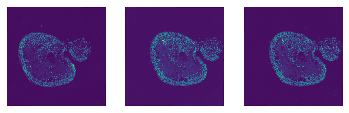

In [42]:
fig, ax = plt.subplots(1,3)
ax[0].imshow(fixed_img_dapi)
ax[1].imshow(sitk.GetArrayFromImage(resultImage))
ax[2].imshow(moving_img_dapi)
for a in ax:
    a.axis("off")

The image above shows the first problem with this approach: The picture in the middle (the resulting picture) looks a lot more like the moving image (right) than the fixed image (left) after the transformation. To me this implies that the first step, i.e. the rigid registration did not work as intended because that should kind of shift the whole thing roughly on top of the fixed image. Another issue is shown in the zoomed in image below, showing that everything is completely distorted.

In [ ]:
ITK_imshow(resultImage)
plt.xlim(3600, 4000)
plt.ylim(2400, 2800)
plt.axis("off")
plt.show()

Tried fixing the translation issue by changing several parameters but to no avail. Removed the code because the only interesting changes were made in the parameter txt files and the resulting images looked no different to the ones above. I checked if the translation works on two brain images shown in the SimpleElastix documentation and that worked perfectly fine. **Code is shown below but removed the two images so rerunning it would result in an error.**

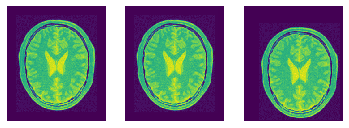

In [50]:
el = sitk.ElastixImageFilter()
el.SetFixedImage(sitk.ReadImage("fixed_image.png"))
el.SetMovingImage(sitk.ReadImage("moving_image.png"))
el.SetParameterMap(sitk.ReadParameterFile("param_maps/translation.txt"))
res = el.Execute()

fig, ax = plt.subplots(1,3)
ax[0].imshow(io.imread("fixed_image.png"))
ax[1].imshow(sitk.GetArrayFromImage(res))
ax[2].imshow(io.imread("moving_image.png"))
for a in ax:
    a.axis("off")

I'll try importing the images already aligned by skimage and then performing the affine and bspline registration on those to see if the results get improved.

In [2]:
# Read images
path_folder = r"/links/groups/treutlein/DATA/imaging/PW/4i/plate6/AlignedOrganoids/MAX_Time00000_Point0000_Point00{ii}_ChannelSCF_SD/cycles"

fixed_img_all = io.imread(os.path.join(path_folder, "cycle3_aligned.tif"))
moving_img_all = io.imread(os.path.join(path_folder, "cycle1_aligned.tif"))

# Extract DAPI channels
fixed_img_dapi = fixed_img_all[..., 2]
moving_img_dapi = moving_img_all[..., 2]

In [4]:
elstx_aligned = sitk.ElastixImageFilter()
elstx_aligned.SetFixedImage(sitk.GetImageFromArray(fixed_img_dapi))
elstx_aligned.SetMovingImage(sitk.GetImageFromArray(moving_img_dapi))
elstx_aligned.SetParameterMap(sitk.ReadParameterFile('param_maps/affine.txt'))
elstx_aligned.AddParameterMap(sitk.ReadParameterFile('param_maps/bspline_32grid.txt'))
img_aligned = elstx_aligned.Execute()

As is shown below, trying the checkerboard comparison doesn't work for some reason.

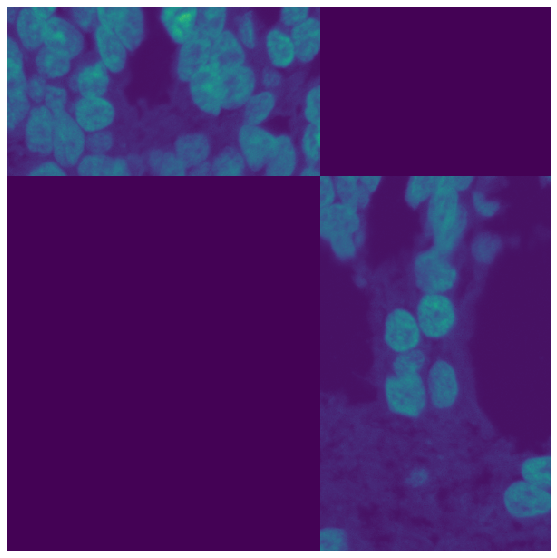

In [128]:
aligned_array = sitk.GetArrayFromImage(img_aligned) # convert image to numpy array

from skimage.util import compare_images

plt.imshow(compare_images(fixed_img_dapi, aligned_array, method="checkerboard"))
plt.xlim(2000, 2600)
plt.ylim(3800, 4400)
plt.axis("off")
plt.show()

In [129]:
from skimage.exposure import rescale_intensity
from skimage.util import img_as_uint
aligned_array[aligned_array < 0] = 0 # some values are below 0. Just capped them at 0 here
aligned_array = rescale_intensity(aligned_array)
aligned_array = img_as_uint(aligned_array) # change bit type to match the other images
fixed_img_resc = rescale_intensity(fixed_img_dapi)
moving_img_resc = rescale_intensity(moving_img_dapi)

By rescaling the intensities this problem can be solved

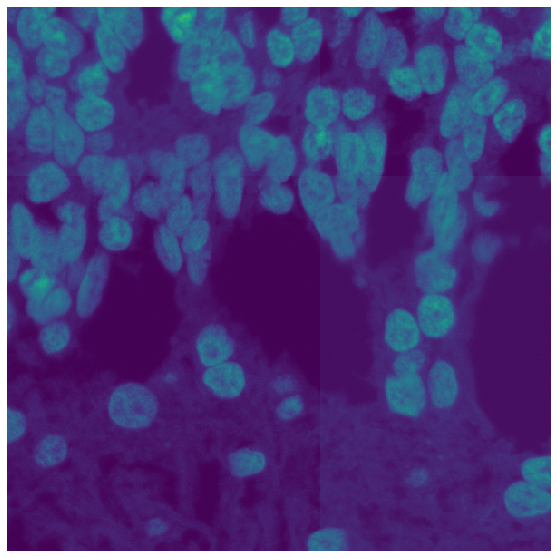

In [131]:
plt.imshow(compare_images(fixed_img_resc, aligned_array, method="checkerboard"))
plt.xlim(2000, 2600)
plt.ylim(3800, 4400)
plt.axis("off")
plt.show()

Now to test whether running elastix improved the alignment. First plotting a part of the original alignment where the checkerboard clearly revealed issues with the alignment. At the right side of the edge between the two areas things are only a little bit off but moving to the left, the alignment gets worse and is off by quite a bit at the very left.

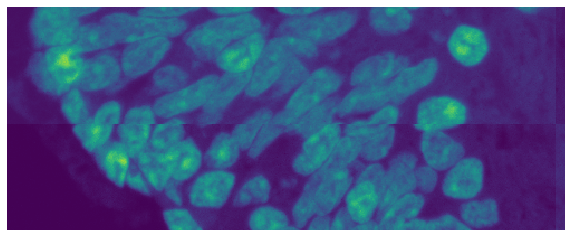

In [132]:
plt.imshow(compare_images(fixed_img_resc, moving_img_resc, method="checkerboard"))
plt.xlim(4200, 4700)
plt.ylim(1900, 1700)
plt.axis("off")
plt.show()

Comparing the image above where on the left the alignemt is clearly off to the result below shows that this seems to have worked very well!

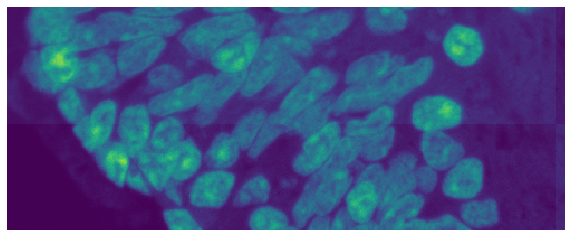

In [133]:
plt.imshow(compare_images(fixed_img_resc, aligned_array, method="checkerboard"))
plt.xlim(4200, 4700)
plt.ylim(1900, 1700)
plt.axis("off")
plt.show()

Comparing this directly to the same are of the fixed image (see below) it's actually very hard to tell any difference between the two.

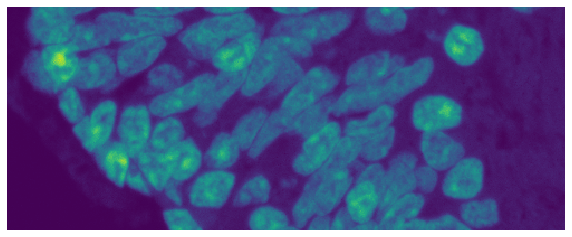

In [134]:
plt.imshow(fixed_img_resc)
plt.xlim(4200, 4700)
plt.ylim(1900, 1700)
plt.axis("off")
plt.show()

In [102]:
# Save images
#plt.imsave("fixed_img_vs_moving_img_checkerboard.png", 
#           compare_images(fixed_img_resc, moving_img_resc, method="checkerboard"))